## Vivacomet
**Vivacomet Notebook, is the combination of diffusion notebook and spatial dFBA notebook.** 
It simulates the environment and growth of organisms within it. The environment is represented as a grid, where each bin contains specific amounts of various molecules that organisms in that bin can utilize. The simulation takes into account the diffusion and advection of molecules, as well as the biomass of species. Additionally, Vivacomet simulates the growth of organisms in each bin, which is influenced by the availability of molecules in that bin.

In [9]:
#imports
import numpy as np
from processes.diffusion_field import DiffusionField
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_objective_flux, plot_fields_temporal
from vivarium.core.engine import Engine
import base64
import shutil
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import imageio.v2 as imageio
import os
import io
import warnings
from vivarium.plots.topology import plot_topology

In [12]:
# Configuration
comets_config = {
    'total_time':10 ,
    'time_step': 1,
    'bounds': [10, 4],
    'nbins': [10, 4],
    'molecules': ['glucose', 'acetate', 'Maltose']
}

# Parameters shared by both processes
shared_params = {
    'bounds': comets_config['bounds'],
    'nbins': comets_config['nbins'],
    'molecules': comets_config['molecules']
}


# Specific parameters for Diffusion Field
diffusion_field_params = {
    **shared_params,
    'default_diffusion_dt': 0.001,
    'default_diffusion_rate': 2E-5,
    'diffusion': {
        'glucose': 2.0E-2,
        'acetate':2.0E-2,
        'Maltose':2.0E-2,
        'Thermotoga': 1.0E-2, 
        'ecoli': 1.0E-2 
    },
    'advection': {
        'glucose': (0.02, -0.03),
        'acetate': (0.02, -0.03),
        'Maltose': (0.02, -0.03),
        'Thermotoga': (0.02, -0.02), # advection vector for Alteromonas
        'ecoli': (0.02, -0.05)
    },
    'clamp_edges': {
        'glucose': 0.5, 
        'acetate': 0.5,
        'Maltose': 0.5,
    }
}

# Specific parameters for Spatial DFBA
spatial_dfba_params = {
    **shared_params,
    'species_info': [
        {
            'name': 'Thermotoga',
            'model': '../data/iLJ478.xml',  # Path to FBA model file 
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'acetate': "EX_ac_e",
                'Maltose': "EX_malt_e"
            },
            'kinetic_params': {
                'glucose': (0.1, 1),  # Km, Vmax for glucose
                'Maltose': (0.1, 0.8)
            },
            # "fixed_bounds": {
            #     'EX_cpd00058_e0': {'lower': -1, 'upper': 1},
            # }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'acetate': 'EX_ac_e',       # Exchange reaction ID for acetate
                "Maltose": "EX_malt_e"
            },
            'kinetic_params': {
                'glucose': (0.1, 1.0)  #(0.4, 5),  # Km, Vmax for glucose
                # 'acetate': (0.1, 1.0),  #(0.4, 5),  # Km, Vmax for glucose
            },
            'fixed_bounds': {
                'EX_o2_e': {'lower': -2},  # Setting fixed bounds for E. coli
                'ATPM': {'lower': 1, 'upper': 1}  # Setting fixed bounds for E. coli
            #         'EX_fe3dhbzs_e': (0, 10)  # Setting fixed bounds for E. coli
            }
        }
    ]
    
}




# Initial state configuration
initial_field_config = {
    'random': {
        'glucose': 2000.0,
        'Maltose': 200.0,
    }}
initial_species_config = {
    'random': {
        'species': {
            'ecoli': 0.5,
            'Thermotoga': 0.5
        }}}


In [13]:
# create the two processes
diffusion_field = DiffusionField(parameters=diffusion_field_params)
spatial_dfba = SpatialDFBA(parameters=spatial_dfba_params)

# set the initial state for diffusion field
initial_state_diffusion_field = diffusion_field.initial_state({'random': 1.0})

# set the initial state for spatial dfba
initial_state_spatial_dfba = spatial_dfba.initial_state(initial_field_config)
initial_species = spatial_dfba.initial_state(initial_species_config)

# merge into initial state
initial_state_spatial_dfba['fields']['glucose'][0, 0] = 0.0  # set glucose to zero in one bin to see the effect

# Merge the initial states
initial_state = {
    'fields': initial_state_diffusion_field['fields'],
    'species': initial_species['species'],
}

# make the composite simulation and run it
sim = Engine(
    processes={
        'diffusion_process': diffusion_field,
        'fba_process': spatial_dfba
    },
    topology={
        'diffusion_process': {
            'fields': ('fields',),
            'species': ('species',),
            'dimensions': ('dimensions',),
        },
        'fba_process': {
            'fields': ('fields',),
            'species': ('species',),
            'exchange_fluxes': ('exchange_fluxes',),
            'dimensions': ('dimensions',),
        }
    },
    initial_state=initial_state
)

sim.update(comets_config['total_time'])

# retrieve the results and plot them
data = sim.emitter.get_timeseries()



Loaded model for Thermotoga
Loaded model for ecoli
No specific initialization for molecule 'acetate', defaulting to zero.
No specific initialization for species 'Thermotoga', defaulting to zero.
No specific initialization for species 'ecoli', defaulting to zero.
No specific initialization for molecule 'glucose', defaulting to zero.
No specific initialization for molecule 'acetate', defaulting to zero.
No specific initialization for molecule 'Maltose', defaulting to zero.

Simulation ID: 14c8f030-33d8-11ef-aded-ba21c95c07d9
Created: 06/26/2024 at 12:21:02
Completed in 39.11 seconds


Writing out/composite_process_topology


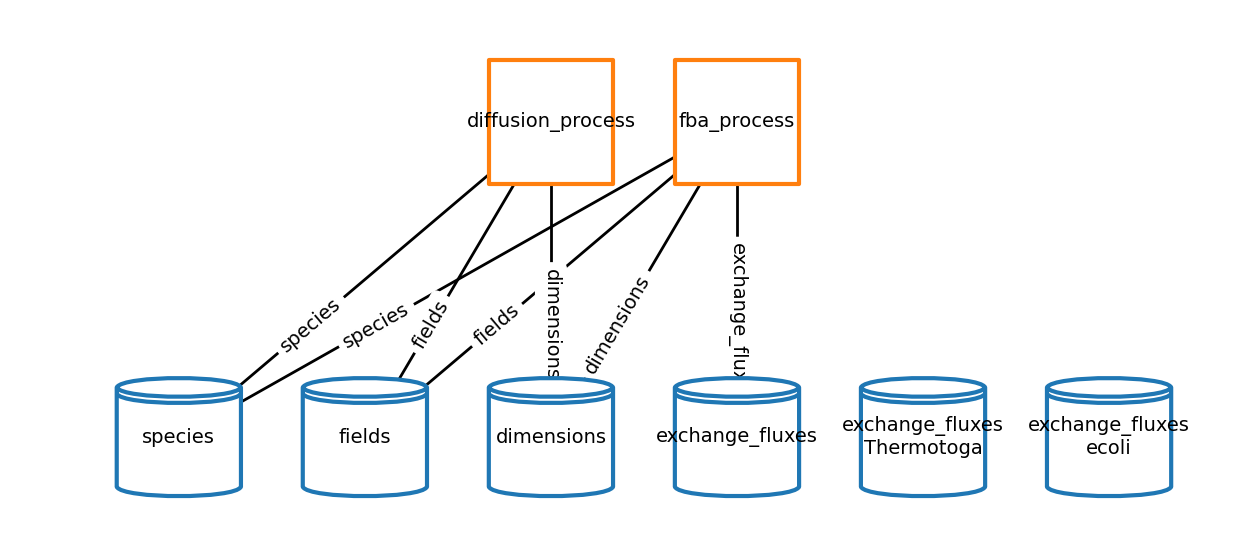

In [16]:
# Imports for the topology plot
from vivarium.plots.topology import plot_topology

# Define the composite with processes, topology, and steps
composite = {
    'processes': {
        'diffusion_process': diffusion_field,
        'fba_process': spatial_dfba
    },
    'topology': {
        'diffusion_process': {
            'fields': ('fields',),
            'species': ('species',),
            'dimensions': ('dimensions',),
        },
        'fba_process': {
            'fields': ('fields',),
            'species': ('species',),
            'exchange_fluxes': ('exchange_fluxes',),
            'dimensions': ('dimensions',),
        }
    },
    'steps': {}  # Include an empty 'steps' key
}

# Plot the topology
fig = plot_topology(
    composite,
    out_dir='out',
    filename='composite_process_topology'
)

# Display the plot
plt.show()


## plot
This grid plot visualizes the temporal changes of biomass (E. coli, Alteromonas, and total) in the top row, while the bottom row depicts the evolving concentrations of glucose and acetate molecules across the grid, influenced by diffusion, advection, and sinking.


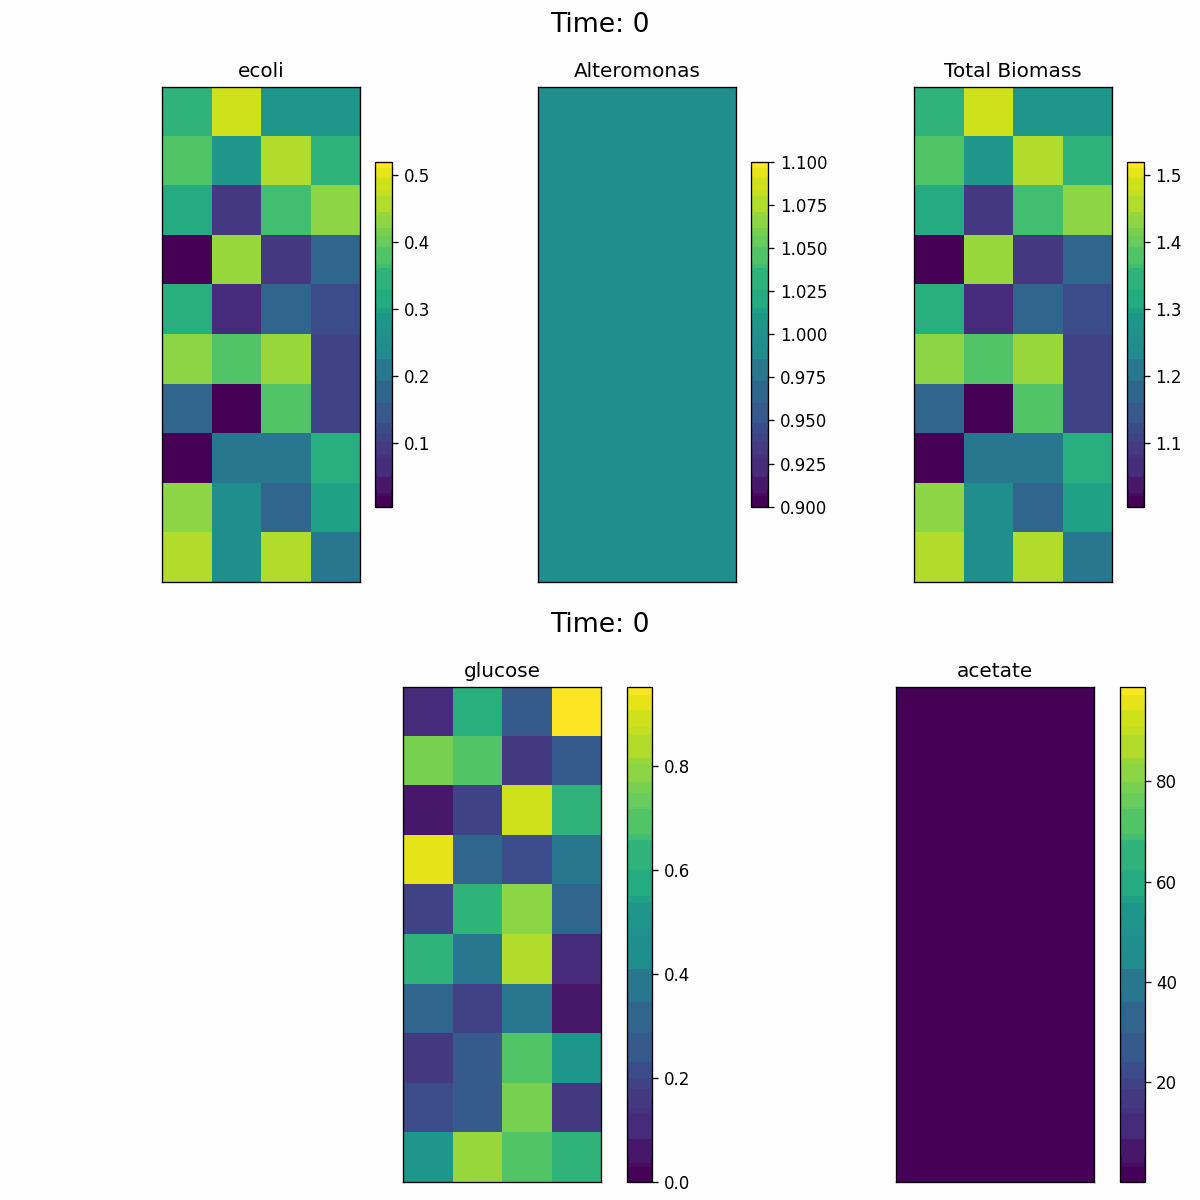

In [8]:
total_time = comets_config["total_time"]

def precompute_global_min_max(data, names, data_key):
    num_elements = len(names)
    global_min = [np.inf] * num_elements
    global_max = [-np.inf] * num_elements

    for time in data["time"]:
        time_index = int(data["time"].index(time))  # Ensure time_index is an integer
        for j, element_id in enumerate(names):
            current_data = data[data_key][element_id][time_index]
            global_min[j] = min(global_min[j], np.min(current_data))
            global_max[j] = max(global_max[j], np.max(current_data))
    
    return global_min, global_max

def plot_elements_to_gif(data, total_time, element_names, data_key, temp_dir, file_prefix, include_total_biomass=False):
    valid_time_points = list(range(total_time + 1))
    num_elements = len(element_names)
    images = []

    global_min, global_max = precompute_global_min_max(data, element_names, data_key)
    
    if include_total_biomass:
        global_min.append(np.inf)
        global_max.append(-np.inf)
        for time in valid_time_points:
            time_index = int(data["time"].index(time))  # Ensure time_index is an integer
            total_biomass = np.zeros_like(data[data_key][element_names[0]][time_index])
            for element_id in element_names:
                total_biomass += data[data_key][element_id][time_index]
            global_min[-1] = min(global_min[-1], np.min(total_biomass))
            global_max[-1] = max(global_max[-1], np.max(total_biomass))

    for time in valid_time_points:
        time_index = int(data["time"].index(time))  # Ensure time_index is an integer
        if include_total_biomass:
            total_biomass = np.zeros_like(data[data_key][element_names[0]][time_index])
        
        fig, axs = plt.subplots(1, num_elements + (1 if include_total_biomass else 0), figsize=(num_elements * 5, 5), squeeze=False)

        for j, element_id in enumerate(element_names):
            current_data = data[data_key][element_id][time_index]
            if include_total_biomass:
                total_biomass += current_data
            im = axs[0, j].imshow(current_data, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(element_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        if include_total_biomass:
            im = axs[0, -1].imshow(total_biomass, cmap='viridis', vmin=global_min[-1], vmax=global_max[-1])
            axs[0, -1].set_title("Total Biomass")
            axs[0, -1].set_xticks([])
            axs[0, -1].set_yticks([])
            plt.colorbar(im, ax=axs[0, -1], fraction=0.046, pad=0.04)

        plt.suptitle(f'Time: {time}', fontsize=16)
        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    for i, img in enumerate(images):
        imageio.imwrite(os.path.join(temp_dir, f'{file_prefix}_{i}.png'), img)

def combine_gifs(output_filename, temp_dir, num_images):
    combined_images = []
    for i in range(num_images):
        obj_flux_img = imageio.imread(os.path.join(temp_dir, f'obj_flux_{i}.png'))
        molecule_img = imageio.imread(os.path.join(temp_dir, f'molecule_{i}.png'))
        
        combined_img = np.vstack((obj_flux_img, molecule_img))
        combined_images.append(combined_img)

    imageio.mimsave(output_filename, combined_images, duration=0.5, loop=0)

    with open(output_filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Combined GIF" style="max-width:100%;"/>'))

temp_dir = 'temp_images'
os.makedirs(temp_dir, exist_ok=True)

plot_elements_to_gif(data, total_time=total_time, element_names=['ecoli', 'Alteromonas'], data_key='species', temp_dir=temp_dir, file_prefix='obj_flux', include_total_biomass=True)
plot_elements_to_gif(data, total_time=total_time, element_names=['glucose', 'acetate'], data_key='fields', temp_dir=temp_dir, file_prefix='molecule')

combine_gifs('combined_over_time.gif', temp_dir, total_time + 1)

shutil.rmtree(temp_dir)
